# Transfer Learning for the Audio Domain with Model Maker

## Intalling dependencies

In [1]:
! pip install tensorflow==2.5rc3

In [2]:
! pip install tflite-model-maker-nightly

## Import TensorFlow, Model Maker and other libraries

In [6]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.5.0-rc3
Model Maker Version: 0.3.1


In [2]:
plt.get_backend()

'module://ipykernel.pylab.backend_inline'

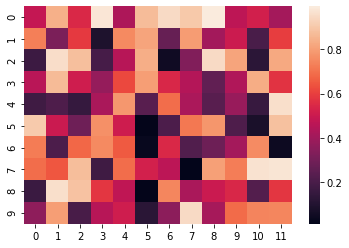

In [7]:
uniform_data = np.random.rand(10, 12)
plt.figure()
ax = sns.heatmap(uniform_data)
plt.show()

## The Birds dataset

The Birds dataset is an education collection of 5 types of birds. 

The original audio came from [Xeno-canto](https://www.xeno-canto.org/) which is a website dedicated to sharing bird sounds from all over the world.

Let's start by downloading the data

This won't be necessary in the final version

The gsutil and unzip will be replaced by tf.keras.utils.get_file

In [7]:
from google.colab import auth
auth.authenticate_user()

In [5]:
# switch to this later!!!
birds_dataset_folder = tf.keras.utils.get_file('birds_dataset',
                                                'gs://birds_datasets/birds_dataset_final.zip',
                                                cache_dir='./',
                                                cache_subdir='test_data',
                                                extract=True)
                                                

Exception: ignored

In [8]:
! gsutil cp gs://birds_datasets/birds_dataset_final.zip .

Copying gs://birds_datasets/birds_dataset_final.zip...
- [1 files][327.8 MiB/327.8 MiB]                                                
Operation completed over 1 objects/327.8 MiB.                                    


In [9]:
! unzip birds_dataset_final.zip

Archive:  birds_dataset_final.zip
   creating: small_birds_dataset/
   creating: small_birds_dataset/test/
   creating: small_birds_dataset/test/chcant2/
  inflating: small_birds_dataset/test/chcant2/XC71346.wav  
  inflating: small_birds_dataset/test/chcant2/XC7221.wav  
  inflating: small_birds_dataset/test/chcant2/XC572620.wav  
  inflating: small_birds_dataset/test/chcant2/XC588250.wav  
  inflating: small_birds_dataset/test/chcant2/XC608572.wav  
  inflating: small_birds_dataset/test/chcant2/XC7222.wav  
  inflating: small_birds_dataset/test/chcant2/XC71347.wav  
  inflating: small_birds_dataset/test/chcant2/XC585286.wav  
  inflating: small_birds_dataset/test/chcant2/XC609906.wav  
  inflating: small_birds_dataset/test/chcant2/XC609905.wav  
   creating: small_birds_dataset/test/wbwwre1/
  inflating: small_birds_dataset/test/wbwwre1/XC525148.wav  
  inflating: small_birds_dataset/test/wbwwre1/XC8080.wav  
  inflating: small_birds_dataset/test/wbwwre1/XC519211.wav  
  inflating: s

## Explore the data

The dataset contains 5 birds:
- White-breasted Wood-Wren
- House Sparrow
- Red Crossbill
- Chestnut-crowned Antpitta
- Azara's Spinetail

The audios are already split in train and test folders. Inside each slit folder, there's one folder for each bird, using their `bird_code` name.
They are also all mono and with 16kHz sample rate.

For more information about each file, you can read the `metadata.csv` file. It contains all the files authors, lincenses and some more information. You won't need to read it yourself on this tutorial.

In [9]:
data_dir = 'small_birds_dataset'

bird_code_to_name = {
  'wbwwre1': 'White-breasted Wood-Wren',
  'houspa': 'House Sparrow',
  'redcro': 'Red Crossbill',  
  'chcant2': 'Chestnut-crowned Antpitta',
  'azaspi1': "Azara's Spinetail",   
}

birds_images = {
  'wbwwre1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', # 	Alejandro Bayer Tamayo from Armenia, Colombia 
  'houspa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', # 	Diliff
  'redcro': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Red_Crossbills_%28Male%29.jpg/640px-Red_Crossbills_%28Male%29.jpg', #  Elaine R. Wilson, www.naturespicsonline.com
  'chcant2': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Chestnut-crowned_antpitta_%2846933264335%29.jpg/640px-Chestnut-crowned_antpitta_%2846933264335%29.jpg', # 	Mike's Birds from Riverside, CA, US
  'azaspi1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg', # https://www.inaturalist.org/photos/76608368
}

test_files = os.path.join('/content', data_dir, 'test/*/*.wav')

/content/small_birds_dataset/test/*/*.wav


### Playing test audio

Lets listen to one of the audio files from the test split

Bird: Azara's Spinetail
Code: azaspi1


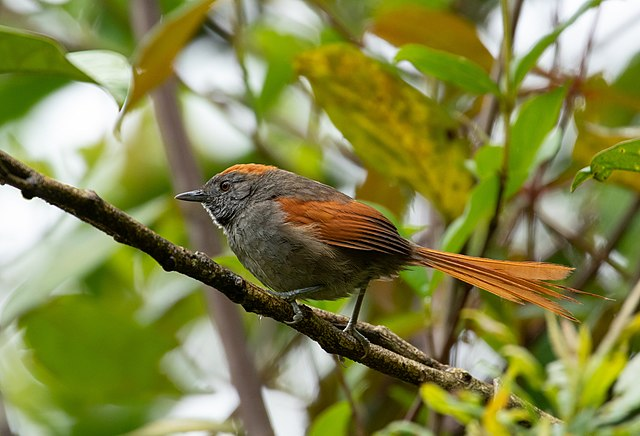

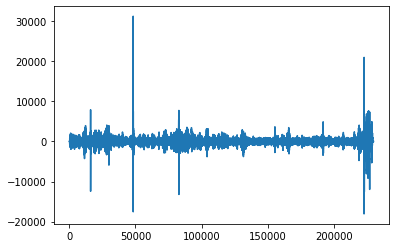

In [14]:
# choose random test audio
test_list = glob.glob(test_files)
random_audio = random.choice(test_list)

bird_code = random_audio.split('/')[-2]
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

print(f'Bird: {bird_code_to_name[bird_code]}')
print(f'Code: {bird_code}')
display(Image(birds_images[bird_code]))

plt.plot(audio_data)
Audio(audio_data, rate=sample_rate)

## Training the Model

When using model maker for audio, you have to start with the base model spec. This affects how the dataset will be transformed to respect the models spec parameters like: sample rate, number of channels.

[YAMNet](https://tfhub.dev/google/yamnet/1) is an audio event classifier trained on the AudioSet dataset to predict audio events from the AudioSet ontology.

It's input is expected to be at 16kHz and with 1 channel.

You don't need to do any conversion yourself. Model Maker takes care of that for you.

In [10]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmppsajmrj9


In [12]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [13]:
batch_size = 128
epochs = 100

print('\nTraining the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)


Training the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classification_head (Dense)  (None, 5)                 5125      
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 34s 1s/step - loss: 1.6186 - acc: 0.2512 - val_loss: 1.5605 - val_acc: 0.2423
Epoch 2/100
23/23 [==============================] - 0s 17ms/step - loss: 1.3442 - acc: 0.4565 - val_loss: 1.4517 - val_acc: 0.4601
Epoch 3/100
23/23 [==============================] - 0s 17ms/step - loss: 1.1990 - acc: 0.5648 - val_loss: 1.3352 - val_acc: 0.5460
Epoch 4/100
23/23 [==============================] - 0s 18ms/step - loss: 1.0645 - acc: 0.6479 - val_loss: 1.2481 - val_acc: 0.5966
Epoch 5/100
23/23 [==============================] - 0s 18ms/step - loss: 0.9837 - acc: 0.6812 - val_

In [14]:
  print('\nEvaluating the model')
  model.evaluate(test_data)


Evaluating the model
28/28 [==============================] - 9s 289ms/step - loss: 0.8679 - acc: 0.8129


[0.8679024577140808, 0.8128587603569031]

## Understanding your model

You can see the confusion matrix of your model and have a deeper understanding of your model and where it might be doing bad predictions.

In [15]:
  confusion_matrix = model.confusion_matrix(test_data)
  print('\nConfusion matrix: ')
  print(confusion_matrix)
  print('labels: ', test_data.index_to_label)


Confusion matrix: 
tf.Tensor(
[[ 80  17   0   6   3]
 [  0 174   0   6  20]
 [  6  33 178  16   2]
 [  1   5  10 149   4]
 [  2  29   3   0 127]], shape=(5, 5), dtype=int32)
labels:  ['azaspi1', 'chcant2', 'houspa', 'redcro', 'wbwwre1']


In [34]:
sns.set_context('notebook')

def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  # confusion = sk_metrics.confusion_matrix(
  #   np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  # print(confusion_normalized)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  # plt.show()

show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [39]:
uniform_data = np.random.rand(10, 12)
plt.figure()
ax = sns.heatmap(uniform_data)
plt.show()

In [29]:
cm = confusion_matrix.numpy()
class_names = test_data.index_to_label
figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Compute the labels from the normalized confusion matrix.
labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Use white text if squares are dark; otherwise black.
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  color = "white" if cm[i, j] > threshold else "black"
  plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure.show()

## [TODO] Testing the model

- add pictures
- add a random pick of audio
- add audio player
- add inference

In [37]:
from IPython.display import Audio
from scipy.io import wavfile

predicts = model.predict_top_k(test_data)
for i, (audio, label) in enumerate(test_data.gen_dataset().unbatch().take(1)):
  print(i, label)
  # file_path = t[0].numpy()
  
# print(file_path)

# sample_rate, wav_data = wavfile.read(file_path, 'rb')
# result = 
# Audio(wav_data, rate=sample_rate)

0 tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [48]:
for t in test_data._dataset.take(1):
  print(t[0])

tf.Tensor(b'/content/small_birds_dataset/test/wbwwre1/XC519209.wav', shape=(), dtype=string)


In [42]:
predicts[2][0]

('wbwwre1', 0.97731245)

## Exporting the model

The last step is exporting your model to be used on embedded devices or on the browser.

The `export` method export both formats for you.

In [17]:
  print('\nExporing the TFLite model to {}'.format('.'))
  model.export('./birds_models', tflite_filename='birds_model.tflite')
    # , 
    #            export_format=mm.audio_classifier.AudioClassifier.DEFAULT_EXPORT_FORMAT)


Exporing the TFLite model to .


NameError: ignored